# Trading on Hourly Return Distributions

This notebook explores the feasibility of using mean reversion to make Bitcoin trades on an hourly time frame. A few assumptions were ma while looking into this:
* Price movements and returns are normally distributed
* Trading fees and price slippage are negligible.
* There are no fees associated with using leverage to augment returns.

Two variants of the strategy were explored, trading off price and trailling returns mean reversion respectively. In each case the strategy is backtested over a 90 day period and compared with Dollar Cost Averaging and Buy and Hold over the same period.

In [1]:
# Utility functions for loading data via the Coingecko API

import os
import json
import requests
import numpy as np
import pandas as pd
from datetime import datetime, timedelta
from matplotlib import pyplot as plt
from scipy.stats import norm

SEED = 123
np.random.seed(SEED)
N_WINDOWS = 5

def format_date(ms):
    dt = datetime.fromtimestamp(ms/1000)
    date = dt.isoformat()
    return date

def build_historical_dataframe(data_dict):
    new_dict = dict()
    dates = [data[0] for data in data_dict['prices']]
    for key in data_dict:
        new_dict[key] = [data[1] for data in data_dict[key]]
    new_dict['Date'] = list(map(format_date, dates))
    dataframe = pd.DataFrame(new_dict)
    dataframe = dataframe.drop(index=dataframe.index[-1])
    return dataframe

def load_dataset(start_date, n_days=90):
    file_name = f'{start_date}_{n_days}days.csv'
    if not os.path.exists(file_name):
        start = datetime.fromisoformat(start_date)
        end = start + timedelta(days=n_days)
        url = 'https://api.coingecko.com/api/v3/coins/bitcoin/market_chart/range'
        parameters = {
            'id':'bitcoin',
            'vs_currency':'usd',
            'from':start.timestamp(),
            'to':end.timestamp()
        }
        response = requests.get(url, params=parameters).text
        data = json.loads(response)
        df = build_historical_dataframe(data)
        df.to_csv(file_name, index=False)
    df = pd.read_csv(file_name)
    return df

Coingecko sets a maximum time window of 90 days for hourly data, so the data is loaded in 90 day increments starting from today.

In [2]:
start_dates = [datetime.now().date() - timedelta(days=90)]
for idx in range(1, N_WINDOWS):
    new_start_date = start_dates[-1] - timedelta(days=90)
    start_dates.append(new_start_date)
datasets = [load_dataset(s.isoformat()) for s in start_dates]

In [3]:
# Visualise one of the dataframes
datasets[0].head()

,prices,market_caps,total_volumes,Date
0,39468.354773,7.493841e+11,2.765346e+10,2022-03-11T00:02:10.713000
1,39308.471112,7.456467e+11,2.734243e+10,2022-03-11T01:01:45.596000
2,38688.815002,7.343096e+11,2.660374e+10,2022-03-11T02:02:51.675000
3,38453.959787,7.296247e+11,2.609268e+10,2022-03-11T03:01:35.043000
4,38815.077850,7.339435e+11,2.623622e+10,2022-03-11T04:02:36.206000


The hourly returns are calculated by dividing the current price by the one before. 

In [4]:
for idx in range(N_WINDOWS):
    datasets[idx]['trailing_returns'] = datasets[idx]['prices'] / datasets[idx]['prices'].shift(1)
    datasets[idx].dropna(inplace=True)
datasets[0].head()

,prices,market_caps,total_volumes,Date,trailing_returns
1,39308.471112,7.456467e+11,2.734243e+10,2022-03-11T01:01:45.596000,0.995949
2,38688.815002,7.343096e+11,2.660374e+10,2022-03-11T02:02:51.675000,0.984236
3,38453.959787,7.296247e+11,2.609268e+10,2022-03-11T03:01:35.043000,0.993930
4,38815.077850,7.339435e+11,2.623622e+10,2022-03-11T04:02:36.206000,1.009391
5,38608.620802,7.333184e+11,2.474332e+10,2022-03-11T05:00:31.417000,0.994681


We can get a sense of the distribution of hourly returns via the plots shown below. This provides a degree of confidence that the assumption of a normal distribution is a fair one to make. 

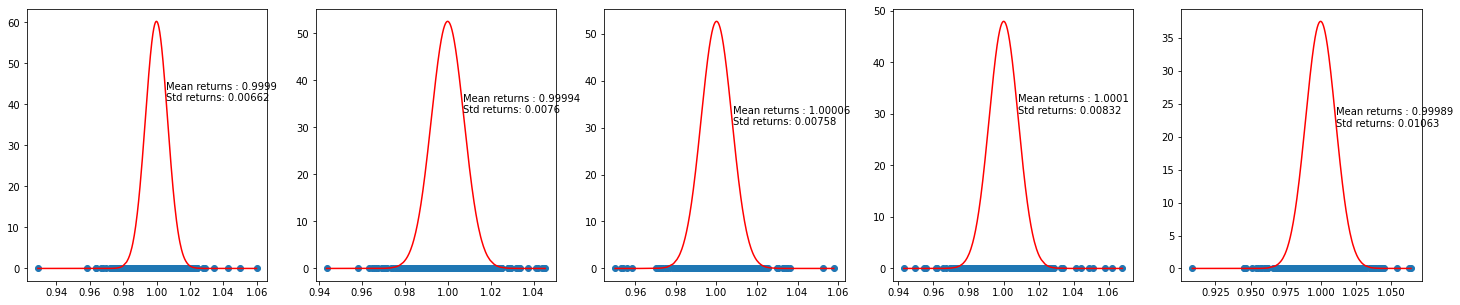

In [5]:
plt.figure(figsize=(25,5))
for idx in range(N_WINDOWS):
    returns = np.sort(datasets[idx]['trailing_returns'].values)
    mu = returns.mean()
    sig = returns.std()
    percentiles = np.quantile(returns, np.arange(0, 1.001, .001))
    density_fn = norm.pdf(percentiles, mu, sig)
    plt.subplot(150+idx+1)
    plt.scatter(returns, np.zeros_like(returns))
    plt.plot(percentiles, density_fn, c='red')
    plt.text(x=percentiles[900], 
             y=density_fn[900],
             s=f'Mean returns : {round(mu, 5)}\nStd returns: {round(sig, 5)}')

## Implementing the Trading Strategy

The ```MeanReversionStrategy``` class implements the trading approach. The ```evaluate_trade``` method takes a ```MarketData``` object with the latest price and volume. If trading off historical prices and volumes, the degree of price and volume deviation is used as a heuristic. If the price and volume are below the defined threshold, we assume that the price is more likely to move up in the next time step assuming the historical price distribution for the length of time stored in the ```len_history``` attribute. Volume was included in the heuristic based on the hypothesis that a price is less likely to be supported of trading volume is low, and is therefore more likely to revert. If using trading returns the strategy implementation treats it in a similar manner to historical prices as described before.

In [6]:
from dataclasses import dataclass
from collections import deque

@dataclass
class MarketData:
    price: float
    volume: float
    trailing_return: float

class MeanReversionStrategy:
    def __init__(self, 
                 len_history=24, 
                 trailing_returns=True, 
                 returns_deviation=0, 
                 price_deviation=0, 
                 volume_deviation=-2):
        self.len_history = len_history
        self.history = deque(maxlen=len_history)
        self.price_threshold = price_deviation
        self.volume_threshold = volume_deviation
        self.returns_threshold = returns_deviation
        self.trailing_returns = trailing_returns
        self.mu = None
        self.sigma = None

    def evaluate_trade(self, data: MarketData):
        buy = 0.

        if self.mu is not None and self.sigma is not None:
            if self.trailing_returns:
                return_dev = (data.trailing_return - self.mu.trailing_return) / self.sigma.trailing_return
                buy = return_dev < self.returns_threshold
            else:
                price_dev = (data.price - self.mu.price) / self.sigma.price
                volume_dev = (data.volume - self.mu.volume) / self.sigma.volume
                price_check = price_dev < self.price_threshold
                volume_check = volume_dev < self.volume_threshold
                buy = price_check and volume_check

        self.update_history(data)
        
        return buy
    
    def update_history(self, data: MarketData):
        self.history.append(data)

        if len(self.history) == self.len_history:
            mu_price = np.mean([d.price for d in self.history])
            mu_volume = np.mean([d.volume for d in self.history])
            mu_returns = np.mean([d.trailing_return for d in self.history])
            sigma_price = np.std([d.price for d in self.history])
            sigma_volume = np.std([d.volume for d in self.history])
            sigma_returns = np.std([d.trailing_return for d in self.history])
            self.mu = MarketData(mu_price, mu_volume, mu_returns)
            self.sigma = MarketData(sigma_price, sigma_volume, sigma_returns)

    def reset(self):
        self.history.clear()
        self.mu = None
        self.sigma = None

In [7]:
def backtest_strategy(strategy: MeanReversionStrategy, 
                      prices: np.array,
                      volumes: np.array,
                      returns: np.array, 
                      start_balance: float = 1000.,
                      leverage=1.):
    len_history = strategy.len_history
    
    # Evaluate performance of "Buy and Hold"
    offset_prices = prices[len_history+1:]
    benchmark_returns = offset_prices / offset_prices[0]
    bh_performance = start_balance * benchmark_returns

    # Evaluate Dollar Cost Averaging
    dca_performance = np.zeros_like(benchmark_returns)
    for idx in range(len(offset_prices)):
        forward_returns = offset_prices[idx:] / offset_prices[idx]
        dca_performance[idx:] += (start_balance/len(offset_prices))*forward_returns
    
    # Evaluate mean reversion strategy
    current_balance = start_balance
    current_bet = 0
    last_price = None
    mr_performance = []
    for price, volume, trailing_return in zip(prices, volumes, returns):
        if last_price is not None:
            ret = leverage * (price - last_price) / last_price
            closed_position = (ret + 1) * current_bet
            current_balance += closed_position
            mr_performance.append(current_balance)
        if price != prices[-1]:
            datapoint = MarketData(price, volume, trailing_return)
            bet_size = strategy.evaluate_trade(datapoint)
            current_bet = current_balance*bet_size
            current_balance -= current_bet
            current_balance = max(current_balance, 0)
            last_price = price
    mr_performance = np.array(mr_performance[len_history:])

    return bh_performance, dca_performance, mr_performance

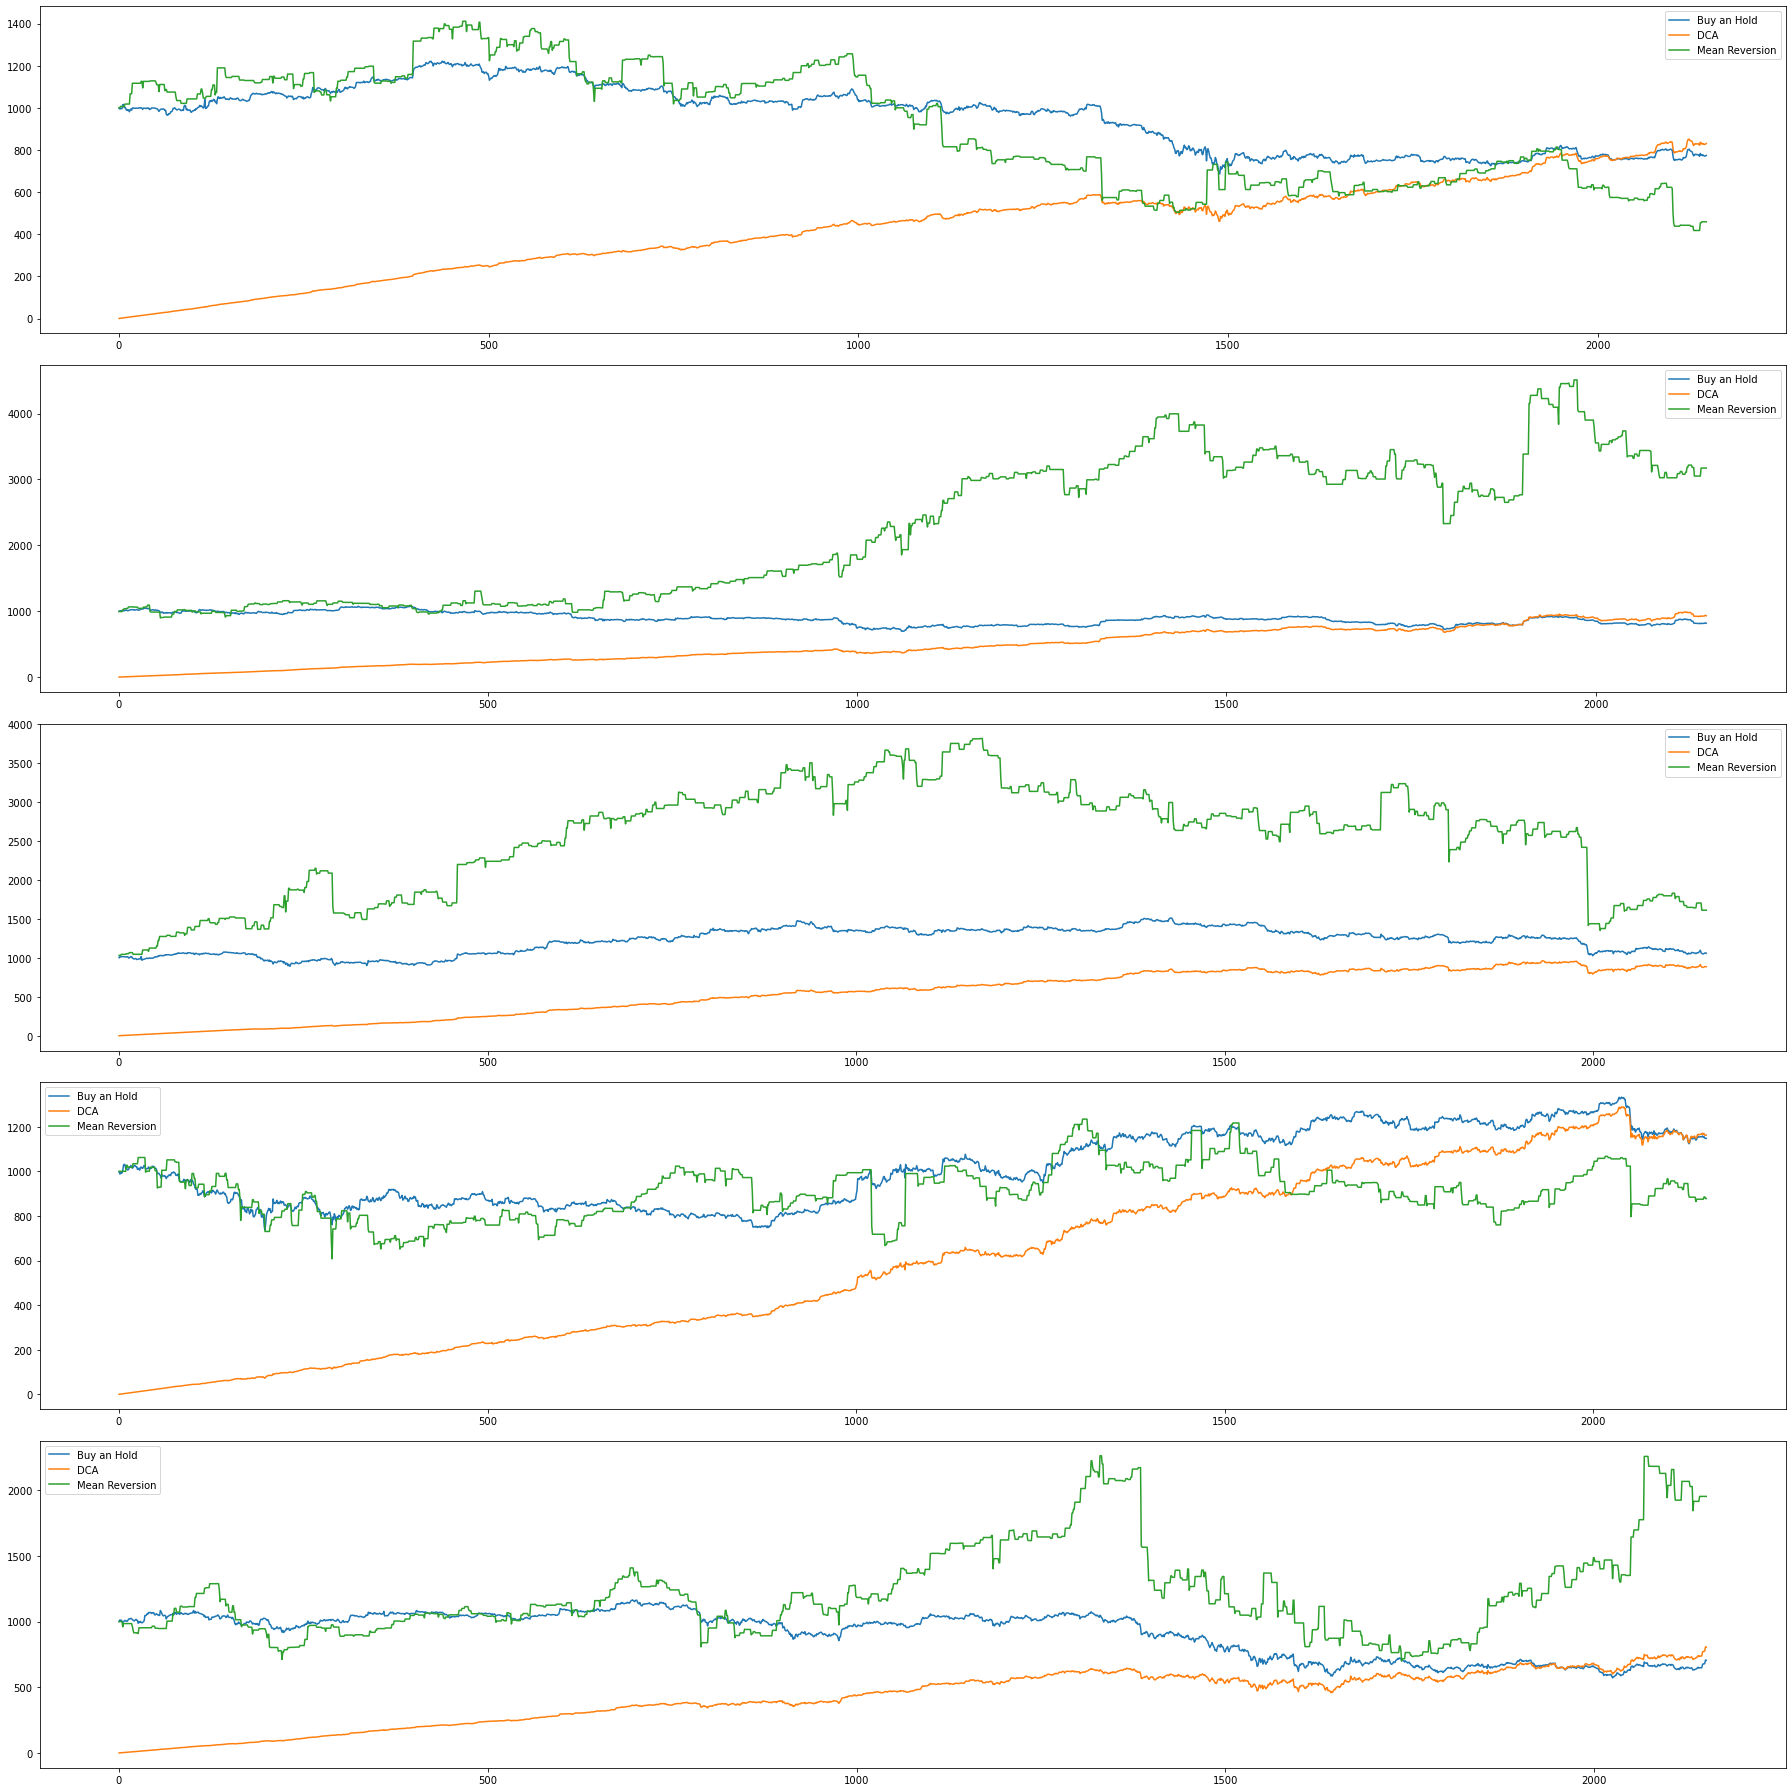

In [8]:
mr_strategy = MeanReversionStrategy(len_history=6, 
                                    trailing_returns=True,
                                    returns_deviation=-1)

results = []

for dataset in datasets:
    result = backtest_strategy(mr_strategy, 
                               dataset['prices'].values, 
                               dataset['total_volumes'].values,
                               dataset['trailing_returns'],
                               leverage=5.)
    results.append(result)
    mr_strategy.reset()

plt.figure(figsize=(25,25))
plot_idx = N_WINDOWS*100 + 11
for bh, dca, mr in results:
    plt.subplot(plot_idx)
    plt.plot(bh)
    plt.plot(dca)
    plt.plot(mr)
    plt.legend(['Buy an Hold', 'DCA', 'Mean Reversion'])
    plot_idx += 1
plt.tight_layout()
plt.show()